In [670]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
from textblob import TextBlob 
import numpy as np
import re
import polyglot
from polyglot.text import Text as T
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [14, 7]

# Collect candidate's tweets

In [671]:
def twitter_setup():
    ####input your credentials here
    consumer_key = '1Bg2vzM5NWPkYhfrp6lrjW0n7'
    consumer_secret = 'MPxboGdEzfZqVDr8yR1XQMCRQeIRPgdBV8ZfHDQ6Jlt77vBNKp'
    access_token = '1051578786075082753-WDUYvUJgINvOB04vVytTZh7RsAkEIM'
    access_token_secret = 'ZGxtieZXJ0qAcncIRpOohB9ubagUsFuS3N9Xut31VCuOW'

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, wait_on_rate_limit=True)
    
     # Return API with authentication:
    api = tweepy.API(auth)
    return api


In [672]:
# We create an extractor object:
extractor = twitter_setup()

alltweets = []

message,favorite_count,retweet_count,created_at,user_name=[],[],[],[],[]

new_tweets = twitter_setup().user_timeline(screen_name = "SutrykJacek",count=200)

for tweet in new_tweets:
    message.append(tweet.text)
    favorite_count.append(tweet.favorite_count)
    retweet_count.append(tweet.retweet_count)
    created_at.append(tweet.created_at)
    
alltweets.extend(new_tweets)

oldest = alltweets[-1].id - 1

while len(new_tweets) > 0:
    

    new_tweets = twitter_setup().user_timeline(screen_name = "SutrykJacek", count=200, max_id=oldest)

    alltweets.extend(new_tweets)

    oldest = alltweets[-1].id - 1
    
    for tweet in new_tweets:
        message.append(tweet.text)
        favorite_count.append(tweet.favorite_count)
        retweet_count.append(tweet.retweet_count)
        created_at.append(tweet.created_at)


data = pd.DataFrame(data=message, columns=['Tweets'])  

df=pd.DataFrame({'Message':message,
                'Favourite Count':favorite_count,
                'Retweet Count':retweet_count,
                'Created At':created_at})
df.to_excel("SutrykJacek.xlsx")



# Read candidate's Tweets

In [682]:
df=pd.read_excel("SutrykJacek.xlsx")

# 2a- candidate's tweets/retweets in time

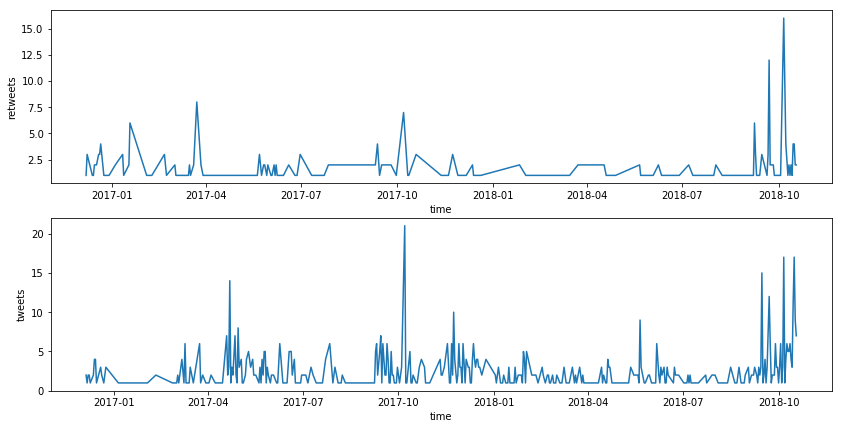

In [683]:
# We create a column with the result of the analysis:
dates_rt=[]
rt= df.loc[df['Message'].str.startswith('RT')]

for i in rt['Created At']:
    dates_rt.append(i.date())

retweets = rt.groupby(dates_rt)['Message'].count()

rt_dates = []
rt_values = []
      
for i, v in retweets.items():
    rt_dates.append(i)
    rt_values.append(v)

plt.subplot(2,1,1)
plt.plot(rt_dates,rt_values)
plt.xlabel('time')
plt.ylabel('retweets')

dates_t = []

t= df.loc[~df['Message'].str.startswith('RT')]

for i in t['Created At']:
    dates_t.append(i.date())

tweets = t.groupby(dates_t)['Message'].count()

t_dates = []
t_values = []
      
for i, v in tweets.items():
    t_dates.append(i)
    t_values.append(v)   

plt.subplot(2,1,2)
plt.plot(t_dates,t_values)
plt.xlabel('time')
plt.ylabel('tweets')


plt.show()



# 2b- popularity of candidate's tweets in time

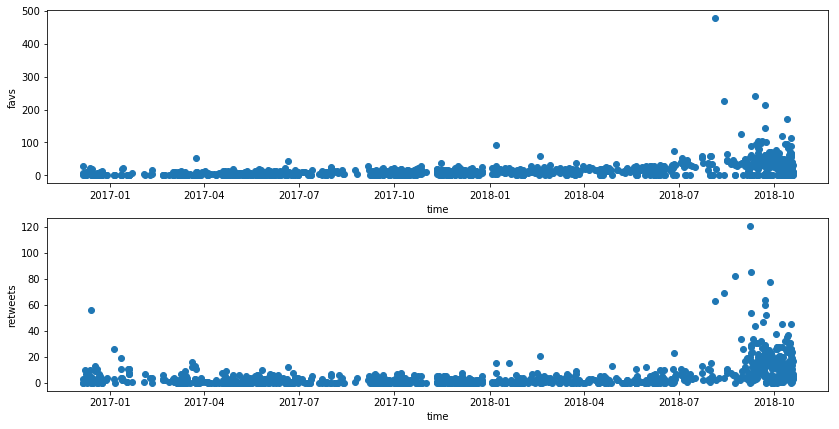

In [684]:
dates = matplotlib.dates.date2num(df['Created At'])
plt.subplot(2,1,1)
plt.plot_date(dates, df['Favourite Count'])
plt.xlabel('time')
plt.ylabel('favs')
plt.subplot(2,1,2)
plt.plot_date(dates,df['Retweet Count'])
plt.xlabel('time')
plt.ylabel('retweets')

plt.show()

# 2c- Distribution of activity

([<matplotlib.axis.XTick at 0xbe766da438>,
 <a list of 7 Text xticklabel objects>)

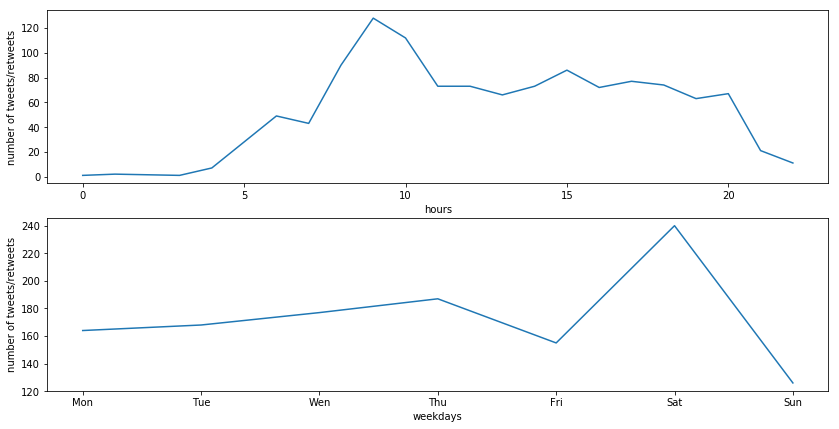

In [685]:
# We create a column with the result of the analysis:
times=[]

for i in df['Created At']:
    times.append(i.hour)

tweets_times = df.groupby(times)['Message'].count()

hours = []
values2 = []
   
for i, v in tweets_times.items():
    hours.append(i)
    values2.append(v)

plt.subplot(2,1,1)
plt.plot(hours,values2)

plt.xlabel('hours')
plt.ylabel('number of tweets/retweets')

# We create a column with the result of the analysis:
weekdays=[]

for i in df['Created At']:
    weekdays.append(i.weekday())

tweets_weekdays = df.groupby(weekdays)['Message'].count()

days = []
values3 = []
   
for i, v in tweets_weekdays.items():
    days.append(i)
    values3.append(v)

plt.subplot(2,1,2)
plt.plot(days,values3)
plt.xlabel('weekdays')
plt.ylabel('number of tweets/retweets')
plt.xticks(np.arange(7), ('Mon', 'Tue', 'Wen', 'Thu', 'Fri','Sat','Sun'))

# 3- Sentiment analysis

In [686]:
def analize_sentiment(tweet):
    
    text = T(tweet) 
    text.language = 'pl'
    text.polarity
    if text.polarity > 0:
        return 1
    elif text.polarity == 0:
        return 0
    else:
        return -1


In [687]:
#add a column with analysis result to a dataframe
df['SA'] = np.array([ analize_sentiment(tweet) for tweet in df['Message'] ])


In [688]:
#lists with analyzed tweets:
pos_tweets = [ tweet for index, tweet in enumerate(df['Message']) if df['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(df['Message']) if df['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(df['Message']) if df['SA'][index] < 0]

Percentage of positive tweets: 21.446179129005753%
Percentage of neutral tweets: 73.62366474938374%
Percentage of negative tweets: 4.930156121610517%


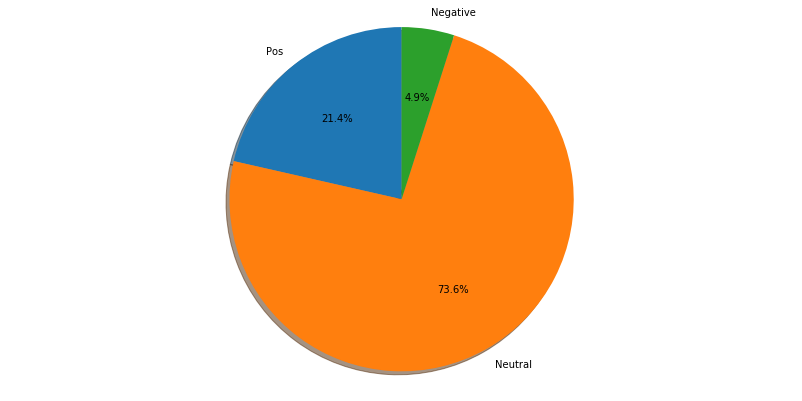

In [689]:
print("Percentage of positive tweets: {}%".format(len(pos_tweets)*100/len(df['Message'])))
print("Percentage of neutral tweets: {}%".format(len(neu_tweets)*100/len(df['Message'])))
print("Percentage of negative tweets: {}%".format(len(neg_tweets)*100/len(df['Message'])))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Pos','Neutral','Negative'
sizes = [len(pos_tweets)*100/len(df['Message']), len(neu_tweets)*100/len(df['Message']), len(neg_tweets)*100/len(df['Message'])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

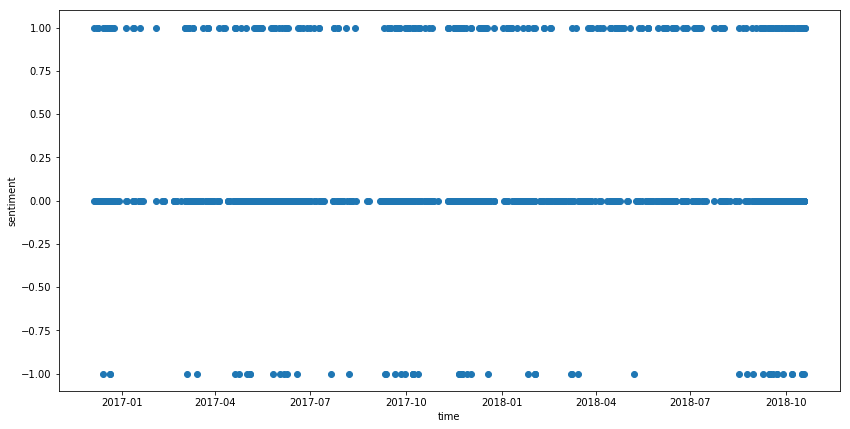

In [690]:
dates = matplotlib.dates.date2num(df['Created At'])
plt.plot_date(dates,df['SA'])
plt.xlabel('time')
plt.ylabel('sentiment')
plt.show